In [1]:
# for the model
from sequence_jacobian.examples.hank import *

# for data generation
from sequence_jacobian.utilities.shocks import simulate
from sequence_jacobian.utilities.plotting import *

# for likelihood evaluation
import sequence_jacobian.estimation as sje

In [18]:
from sequence_jacobian import create_model, ShockDict, Uniform, Prior, AR
import pymc as mc
import arviz as az

# for custom likelihood declaration
import pytensor
import pytensor.tensor as pt
from pytensor.graph import Apply, Op

In [3]:
household = hh.add_hetinputs([transfers, wages, make_grids])
household = household.add_hetoutputs([labor_supply])

blocks = [household, firm, monetary, fiscal, mkt_clearing, nkpc]
hank_model = create_model(blocks, name="One-Asset HANK")

In [4]:
calibration = {
    "r": 0.005,
    "rstar": 0.005,
    "eis": 0.5,
    "frisch": 0.5,
    "B": 5.6,
    "mu": 1.2,
    "rho_s": 0.966,
    "sigma_s": 0.5,
    "kappa": 0.1,
    "phi": 1.5,
    "Y": 1.0,
    "Z": 1.0,
    "pi": 0.,
    "nS": 2,
    "amax": 150,
    "nA": 10
}

In [5]:
unknowns_ss = {"beta": 0.986, "vphi": 0.8}
targets_ss = {"asset_mkt": 0.0, "NE": 1.0}

blocks_ss = [household, firm, monetary, fiscal, mkt_clearing, nkpc_ss]
hank_model_ss = create_model(blocks_ss, name="One-Asset HANK SS")

cali = hank_model_ss.solve_steady_state(
    calibration, unknowns_ss, targets_ss, solver="broyden_custom"
)

ss = hank_model.steady_state(cali)

In [6]:
unknowns = ["w", "Y", "pi"]
targets = ["asset_mkt", "goods_mkt", "nkpc_res"]
inputs = ["rstar", "Z"]
outputs = ["Y", "pi"]
T = 500

In [7]:
shocks = ShockDict({
    "rstar": AR(np.array([0.7]), 1.0),
    "Z": AR(np.array([0.8]), 0.5)
})

ar_prior = Prior({
    "phi": Uniform(-0.99, 0.99),
    "sigma": Uniform(0.05, 1.5)
})

shock_prior = Prior({i: ar_prior for i in inputs})

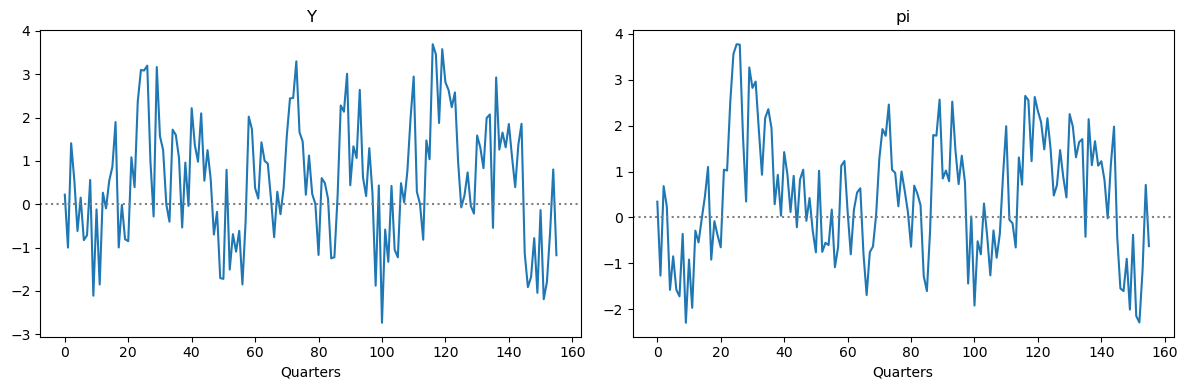

In [8]:
G = hank_model.solve_jacobian(ss, unknowns, targets, inputs, outputs, T=T)

impulses = shocks.generate_impulses(T)
irfs = {i: G @ {i: impulses[i]} for i in inputs}

data_simul = simulate(list(irfs.values()), outputs, 156)
plot_timeseries(data_simul, figsize=(12, 4))

Y = np.empty((156, len(outputs)))
for no, o in enumerate(outputs):
    Y[:, no] = data_simul[o]

In [28]:
# this is slowing shit down for some reason (maybe references to globals?)
def dsge_likelihood(phi_rstar, sigma_rstar, phi_Z, sigma_Z, data, jacobian):
    # construct shocks
    shocks = ShockDict({
        "rstar": AR(np.array([phi_rstar]), sigma_rstar),
        "Z": AR(np.array([phi_Z]), sigma_Z)
    })

    # construct impulse response functions
    impulses = shocks.generate_impulses(T)
    irfs = {i: jacobian @ {i: impulses[i]} for i in inputs}

    M = np.empty((T, len(outputs), len(inputs)))
    for no, o in enumerate(outputs):
        for ns, s in enumerate(inputs):
            M[:, no, ns] = irfs[s][o]
    
    # approximate the autocovariances
    Sigma = sje.all_covariances(M, 1)
    
    # compute the log posterior likelihood
    return sje.log_likelihood(data, Sigma)

class DSGELikelihood(Op):
    def __init__(self, data, jacobian):
        self.data = data
        self.jacobian = jacobian
        super().__init__()

    def make_node(self, phi_rstar, sigma_rstar, phi_Z, sigma_Z) -> Apply:
        # Convert inputs to tensor variables
        phi_rstar = pt.as_tensor(phi_rstar)
        sigma_rstar = pt.as_tensor(sigma_rstar)
        phi_Z = pt.as_tensor(phi_Z)
        sigma_Z = pt.as_tensor(sigma_Z)

        inputs = [phi_rstar, sigma_rstar, phi_Z, sigma_Z]
        outputs = [pt.dscalar()]

        # Apply is an object that combines inputs, outputs and an Op (self)
        return Apply(self, inputs, outputs)

    def perform(self, node: Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        # unpack inputs
        phi_rstar, sigma_rstar, phi_Z, sigma_Z = inputs

        # evaluate likelihood
        logposterior = dsge_likelihood(
            phi_rstar, sigma_rstar, phi_Z, sigma_Z, self.data, self.jacobian
        )
        
        # set the output storage accordingly
        outputs[0][0] = np.asarray(logposterior)

In [29]:
# define the density evaluator
dsge_logpdf = DSGELikelihood(Y, G)

# define the priors and calculate the logpdf
with mc.Model() as hank:
    # rstar shock params
    phi_rstar = mc.Uniform("phi_rstar", lower=-0.99, upper=0.99)
    sigma_rstar = mc.InverseGamma("sigma_rstar", alpha=3, beta=1)
    
    # Z shock params
    phi_Z = mc.Uniform("phi_Z", lower=-0.99, upper=0.99)
    sigma_Z = mc.InverseGamma("sigma_Z", alpha=3, beta=1)

    likelihood = mc.Potential(
        "likelihood",
        dsge_logpdf(phi_rstar, sigma_rstar, phi_Z, sigma_Z)
    )

    chains = mc.sample(1500, cores=2, tune=500, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [phi_rstar]
>Slice: [sigma_rstar]
>Slice: [phi_Z]
>Slice: [sigma_Z]


Output()

Sampling 2 chains for 500 tune and 1_500 draw iterations (1_000 + 3_000 draws total) took 535 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


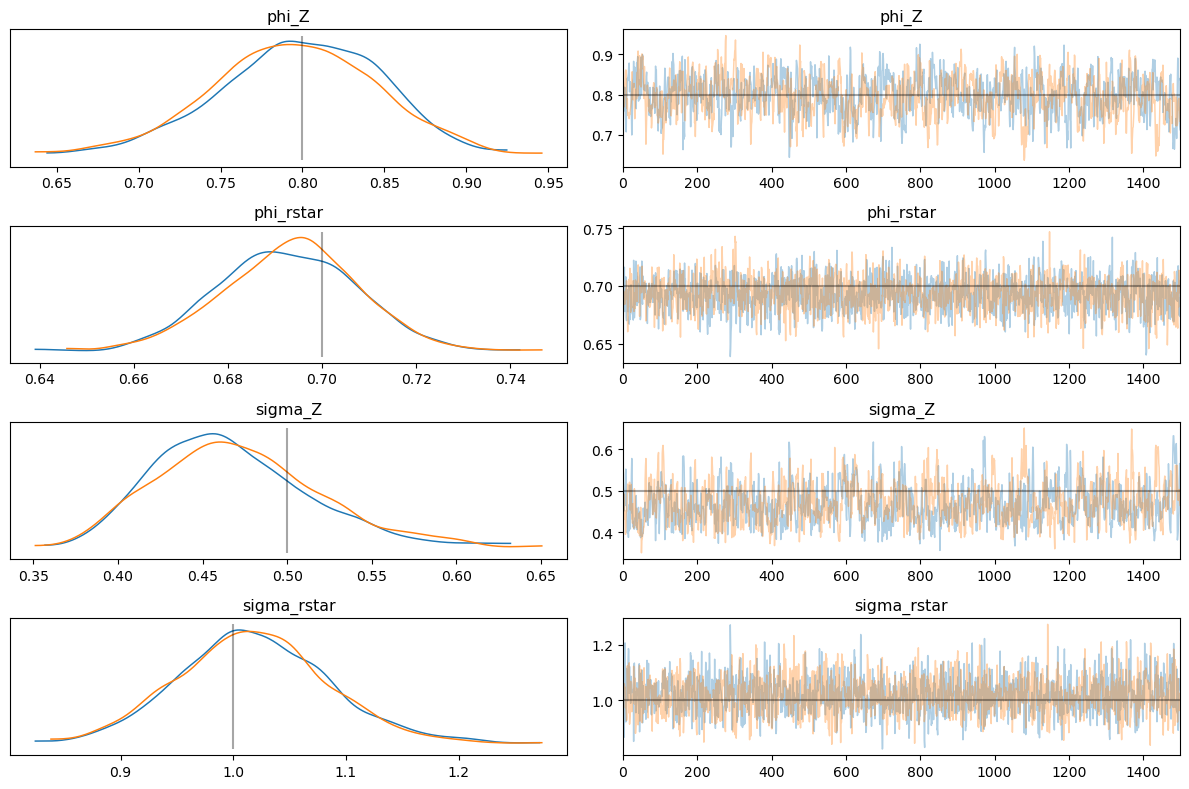

In [34]:
# use arviz to visualize the posterior draws for MCMC
az.plot_trace(
    chains,
    lines = [
        ("phi_rstar", {}, 0.7),
        ("sigma_rstar", {}, 1.0),
        ("phi_Z", {}, 0.8),
        ("sigma_Z", {}, 0.5)
    ],
    compact = False
)

# fixes the header on the graphs
mpl.tight_layout()